<a href="https://colab.research.google.com/github/puzis/llmnet/blob/main/experiments/gpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [1]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np

In [ ]:
dataset = load_dataset("imdb")
inputs = dataset['train']['text'][:5]

In [ ]:
dataset = load_dataset("glue", "mrpc")
inputs = dataset['train']['sentence1'][:15]

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("uer/gpt2-chinese-cluecorpussmall")
model = AutoModelForCausalLM.from_pretrained("uer/gpt2-chinese-cluecorpussmall")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
tokenizer = AutoTokenizer.from_pretrained("Graphcore/gpt2-wikitext-103")
model = AutoModelWithLMHead.from_pretrained("Graphcore/gpt2-wikitext-103")
tokenizer.pad_token = tokenizer.eos_token
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [4]:
import torch
import torch.nn as nn

class GPT2FeatureExtractor(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2FeatureExtractor, self).__init__()
        self.gpt2_model = gpt2_model
        self.layer_features = {'ln_1': [], 'ln_2': [], 'attn': [], 'mlp': []}
        self.nlf_features = []  # Updated to store as a list
        self.embedding_features = None  # Updated to store as a tensor

        # Register hooks for each module
        for i, layer in enumerate(self.gpt2_model.transformer.h):
            layer_name = f"layer_{i + 1}"
            self.layer_features[layer_name] = {
                'ln_1': None,
                'ln_2': None,
                'attn': None,
                'mlp': None
            }

            layer.ln_1.register_forward_hook(self.ln_1_hook(layer_name))
            layer.ln_2.register_forward_hook(self.ln_2_hook(layer_name))
            layer.attn.register_forward_hook(self.attn_hook(layer_name))
            layer.mlp.register_forward_hook(self.mlp_hook(layer_name))

        # Register hook for ln_f after the last layer
        self.gpt2_model.transformer.ln_f.register_forward_hook(self.nlf_hook)

        # Register hook for the embedding layer
        self.gpt2_model.transformer.wte.register_forward_hook(self.embedding_hook)

    def ln_1_hook(self, layer_name):
        def hook(module, input, output):
            self.layer_features[layer_name]['ln_1'] = output
        return hook

    def ln_2_hook(self, layer_name):
        def hook(module, input, output):
            self.layer_features[layer_name]['ln_2'] = output
        return hook

    def attn_hook(self, layer_name):
        def hook(module, input, output):
            self.layer_features[layer_name]['attn'] = output
        return hook

    def mlp_hook(self, layer_name):
        def hook(module, input, output):
            self.layer_features[layer_name]['mlp'] = output
        return hook

    def nlf_hook(self, module, input, output):
        # Store the hidden features of ln_f after the last layer
        self.nlf_features.append(output)

    def embedding_hook(self, module, input, output):
        # Store the hidden features of the embedding layer
        self.embedding_features = output

    def forward(self, input_ids, attention_mask=None):
        # Reset hidden features
        for layer_name in self.layer_features:
            for sub_module in self.layer_features[layer_name]:
                self.layer_features[layer_name][sub_module] = None

        self.nlf_features = []  # Reset ln_f features
        self.embedding_features = None  # Reset embedding features

        # Forward pass through the GPT-2 model
        outputs = self.gpt2_model(input_ids, attention_mask=attention_mask)

        # Return the stored hidden features
        return {
            'layers': self.layer_features,
            'nlf': self.nlf_features,
            'embedding': self.embedding_features
        }

In [18]:
feature_extractor = GPT2FeatureExtractor(model)
hidden_features = feature_extractor(encoded_input['input_ids'],encoded_input['attention_mask'])

In [12]:
main = torch.empty(0)
for i in range (encoded_input['input_ids'].shape[0]):
  temp = torch.empty(0)
  temp = torch.cat((temp, hidden_features['embedding'][i, :, :]), 0)
  for j in range(1,13):
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['ln_1'][i,:,:]),0)
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['attn'][0][i,:,:]), 0)
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['attn'][1][0][i,:,:].reshape(encoded_input['input_ids'].shape[1],64*12)), 0)
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['attn'][1][1][i,:,:].reshape(encoded_input['input_ids'].shape[1],64*12)), 0)
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['ln_2'][i,:,:]),0)
    temp = torch.cat((temp, hidden_features['layers'][f'layer_{j}']['mlp'][i,:,:]),0)
  main = torch.cat((main, temp), 1)

In [14]:
corr = torch.corrcoef(main)

In [15]:
degree_distribution = torch.sum(corr, dim=0)

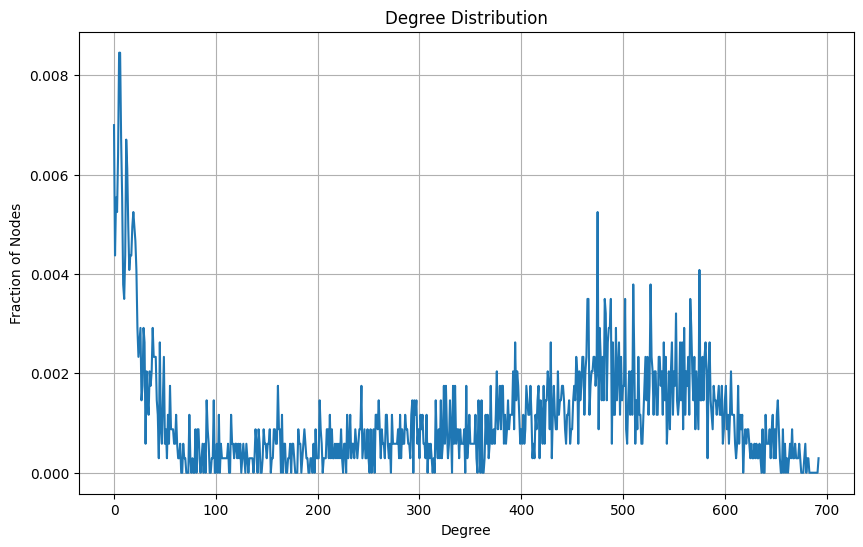

In [16]:
degree_counts = torch.bincount(degree_distribution[degree_distribution >= 0].int())
degree_fractions = degree_counts / degree_distribution.shape[0]

plt.figure(figsize=(10, 6))
plt.plot(degree_fractions.cpu())
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(True)
plt.show()